In [1]:
import tensorflow as tf

from tensorflow.keras import models, layers, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, ZeroPadding2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

import matplotlib.pyplot as plt

import os
import PIL
import numpy as np
import pandas as pd

In [2]:
input_img = tf.keras.Input(shape=(224, 224, 3))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoded')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same', name='DecoderStart')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.Model(input_img, decoded)
# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [3]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 8)       1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 8)         584   

In [4]:
# This model maps an input to its encoded representation
encoder = tf.keras.Model(input_img, encoded)
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 8)       1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 8)         584 

In [5]:
encoded_input = autoencoder.get_layer(name='DecoderStart').input
decoder = tf.keras.Model(encoded_input, decoded)
decoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 8)]       0         
                                                                 
 DecoderStart (Conv2D)       (None, 28, 28, 8)         584       
                                                                 
 up_sampling2d (UpSampling2D  (None, 56, 56, 8)        0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 8)         584       
                                                                 
 up_sampling2d_1 (UpSampling  (None, 112, 112, 8)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 16)      1168

In [6]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')

In [7]:
ImageSize = (224, 224)

In [8]:
noize = []
for filename in os.listdir('./pikachu_train/Pikachu/'):
    if filename == '.DS_Store':
        continue
    noize.append(PIL.Image.open('./pikachu_train/Pikachu/'+filename).convert("RGB").resize(ImageSize))

/Users/krc/miniforge3/envs/dl/lib/python3.8/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [14]:
for i in range(len(noize)):
    noize[i]= np.asarray(noize[i]).astype('float32')/255.

In [15]:
noise_factor = 0.5
for i in range(len(noize)):
    noize[i] = noize[i] + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=(224,224,3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


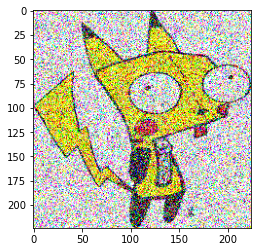

In [16]:
plt.imshow(noize[1])
plt.show()

In [17]:
noize_fin = np.stack(noize, axis=0)

In [18]:
train=[]
for filename in os.listdir('./pikachu_train/Pikachu/'):
    if filename == '.DS_Store':
        continue
    train.append(PIL.Image.open('./pikachu_train/Pikachu/'+filename).convert("RGB").resize(ImageSize))

/Users/krc/miniforge3/envs/dl/lib/python3.8/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [19]:
for i in range(len(train)):
    train[i]= np.asarray(train[i]).astype('float32')/255.

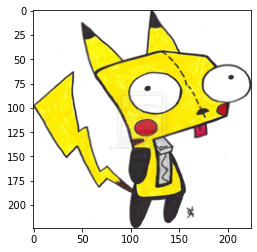

In [20]:
plt.imshow(train[1])
plt.show()

In [21]:
train_fin = np.stack(train, axis=0)

In [22]:
train_fin

array([[[[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        ...,

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]

In [28]:
autoencoder.fit(noize_fin,train_fin,
                epochs=15,
                batch_size=32,
                shuffle=True)

Epoch 1/15
10/10 [==============================] - 4s 376ms/step - loss: 0.6853 - acc: 0.0853
Epoch 2/15
10/10 [==============================] - 4s 376ms/step - loss: 0.5990 - acc: 0.0813
Epoch 3/15
10/10 [==============================] - 4s 376ms/step - loss: 0.4458 - acc: 0.2016
Epoch 4/15
10/10 [==============================] - 4s 374ms/step - loss: 0.4088 - acc: 0.6975
Epoch 5/15
10/10 [==============================] - 4s 379ms/step - loss: 0.3882 - acc: 0.2274
Epoch 6/15
10/10 [==============================] - 4s 379ms/step - loss: 0.3774 - acc: 0.4886
Epoch 7/15
10/10 [==============================] - 4s 377ms/step - loss: 0.3705 - acc: 0.5007
Epoch 8/15
10/10 [==============================] - 4s 378ms/step - loss: 0.3632 - acc: 0.4582
Epoch 9/15
10/10 [==============================] - 4s 377ms/step - loss: 0.3580 - acc: 0.5096
Epoch 10/15
10/10 [==============================] - 4s 376ms/step - loss: 0.3531 - acc: 0.4771
Epoch 11/15
10/10 [==============================

In [29]:
result = autoencoder.predict(noize_fin)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


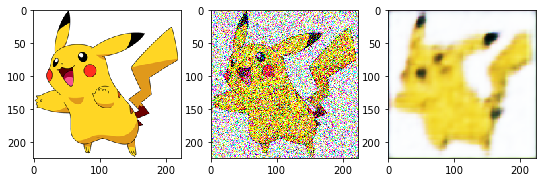

In [36]:
fig = plt.figure(figsize=(9, 3))


fig.add_subplot(1, 3, 1) # row, column, n번째 image
plt.imshow(train_fin[200], interpolation='nearest')

fig.add_subplot(1, 3, 2) # row, column, n번째 image
plt.imshow(noize_fin[200], interpolation='nearest')

fig.add_subplot(1, 3, 3)
plt.imshow(result[200], interpolation='nearest')

In [45]:
import cv2

In [46]:
sketch=[]
for filename in os.listdir('./pikachu_train/Pikachu/'):
    if filename == '.DS_Store':
        continue
    sketch.append(cv2.imread('./pikachu_train/Pikachu/'+filename))

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


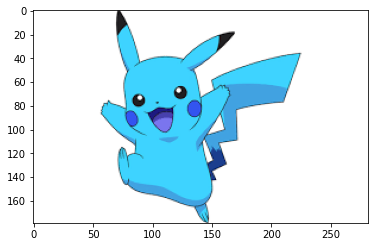

In [26]:
plt.imshow(sketch[0])

In [129]:
# sketch = []
# for filename in os.listdir('./pikachu_train/Pikachu/'):
#     if filename == '.DS_Store':
#         continue
#     sketch.append(PIL.Image.open('./pikachu_train/Pikachu/'+filename).convert("RGB").resize(ImageSize))

In [130]:
# for i in range(len(sketch)):
#     sketch[i]= np.asarray(train[i]).astype('float32')

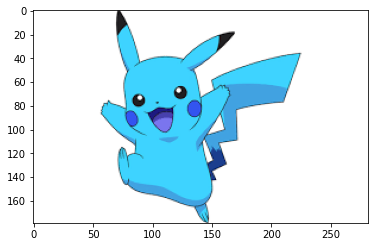

In [27]:
plt.imshow(sketch[0])

In [28]:
for i in range(len(sketch)):
    gray = cv2.cvtColor(sketch[i],cv2.COLOR_RGB2GRAY)
    invert = cv2.bitwise_not(gray)
    blur = cv2.GaussianBlur(invert, (21, 21), 0)
    invertedblur = cv2.bitwise_not(blur)
    sketch[i] = cv2.divide(gray, invertedblur, scale=256.0)

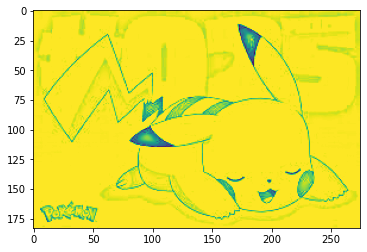

In [29]:
plt.imshow(sketch[4])

In [30]:
for i in range(len(sketch)):
    sketch[i] = cv2.cvtColor(sketch[i],cv2.COLOR_BGR2RGB)
    sketch[i] = cv2.resize(sketch[i], dsize=(224, 224), interpolation=cv2.INTER_CUBIC)

In [31]:
sketch[0].shape

(224, 224, 3)

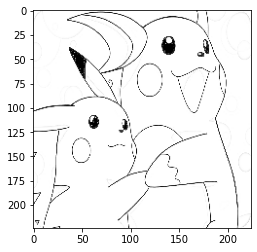

In [32]:
plt.imshow(sketch[2])

In [33]:
for i in range(len(sketch)):
    sketch[i] = sketch[i].astype('float32')/255.

In [34]:
sketch[0]

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]], dtype=float32)

In [35]:
sketch_fin = np.stack(sketch, axis=0)

In [38]:
CP = ModelCheckpoint(filepath='auto_encoder.hdf5',
            monitor='acc', verbose=1, save_best_only=True, mode='max')

# Learning Rate 줄여나가기
LR = ReduceLROnPlateau(monitor='loss',factor=0.8,patience=3, verbose=1, min_lr=1e-8)

CALLBACK = [CP,LR]

In [40]:
autoencoder.fit(sketch_fin,train_fin,
                epochs=30,
                batch_size=32,
                shuffle=True,
                callbacks=CALLBACK)

Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 0.5607 - acc: 0.7086
Epoch 1: acc improved from -inf to 0.70858, saving model to auto_encoder.hdf5
10/10 [==============================] - 4s 412ms/step - loss: 0.5607 - acc: 0.7086 - lr: 0.0010
Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 0.5421 - acc: 0.7000
Epoch 2: acc did not improve from 0.70858
10/10 [==============================] - 4s 411ms/step - loss: 0.5421 - acc: 0.7000 - lr: 0.0010
Epoch 3/30
10/10 [==============================] - ETA: 0s - loss: 0.5345 - acc: 0.6870
Epoch 3: acc did not improve from 0.70858
10/10 [==============================] - 4s 396ms/step - loss: 0.5345 - acc: 0.6870 - lr: 0.0010
Epoch 4/30
10/10 [==============================] - ETA: 0s - loss: 0.5321 - acc: 0.6993
Epoch 4: acc did not improve from 0.70858
10/10 [==============================] - 4s 388ms/step - loss: 0.5321 - acc: 0.6993 - lr: 0.0010
Epoch 5/30
10/10 [==============================] - 

In [41]:
model = tf.keras.models.load_model('auto_encoder.hdf5')

In [42]:
result = model.predict(sketch_fin)

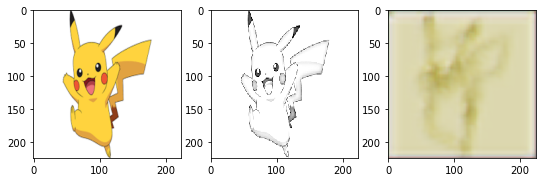

In [44]:
fig = plt.figure(figsize=(9, 3))


fig.add_subplot(1, 3, 1) # row, column, n번째 image
plt.imshow(train_fin[0])

fig.add_subplot(1, 3, 2) # row, column, n번째 image
plt.imshow(sketch_fin[0], interpolation='nearest')

fig.add_subplot(1, 3, 3)
plt.imshow(result[0])

In [130]:
result[0]

array([[[0.49405625, 0.526858  , 0.51397437],
        [0.51314145, 0.547585  , 0.5113538 ],
        [0.5206154 , 0.5473592 , 0.51749694],
        ...,
        [0.53448945, 0.5368071 , 0.40953708],
        [0.5210649 , 0.52649754, 0.4040533 ],
        [0.4952748 , 0.50936043, 0.46626234]],

       [[0.5373303 , 0.5530221 , 0.5104952 ],
        [0.5516898 , 0.5724409 , 0.53424305],
        [0.582905  , 0.59775305, 0.5380082 ],
        ...,
        [0.648027  , 0.5858857 , 0.46644917],
        [0.5978652 , 0.5429635 , 0.46288982],
        [0.55381376, 0.51899636, 0.4649157 ]],

       [[0.54304415, 0.569543  , 0.5312505 ],
        [0.57432395, 0.6011822 , 0.54166096],
        [0.5956668 , 0.6345327 , 0.57677466],
        ...,
        [0.7019344 , 0.614222  , 0.5306642 ],
        [0.6586008 , 0.55987674, 0.48582405],
        [0.585435  , 0.52992105, 0.47444016]],

       ...,

       [[0.6438399 , 0.6456461 , 0.5483023 ],
        [0.76161504, 0.71230173, 0.676668  ],
        [0.7975842 , 0

In [ ]:
Website/static/sketch_00000001.png

In [148]:
aa =cv2.imread('./Website/static/sketch_00000001.png')

In [149]:
aa = tf.expand_dims(aa,axis=0)

In [150]:
res = model.predict(aa)

In [152]:
res = res[0]

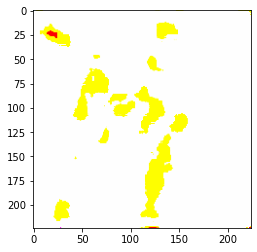

In [153]:
plt.imshow(res)

In [35]:
train_directory = './pikachu_train/'
test_directory = './pikachu_sketch/'
batch_size = 32
img_width = 224
img_height = 224

In [36]:
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last",
    validation_split=0.10) # Train / Validation

# Online-augmentation 비적용 Generator (Test용)
datagen_test = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last")

In [37]:
train_gen = datagen_train.flow_from_directory(
    train_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode= "input",
    subset = "training")

valid_gen = datagen_train.flow_from_directory(
    train_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode="input",
    subset = "validation")

# Generator의 instance 생성 (Test)
test_gen = datagen_test.flow_from_directory(
    test_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False,
    class_mode='binary')

Found 270 images belonging to 1 classes.
Found 29 images belonging to 1 classes.
Found 28 images belonging to 1 classes.


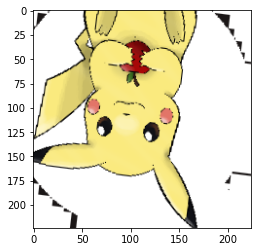

In [38]:
plt.imshow(train_gen.__getitem__(0)[0][23])
plt.show()

In [39]:
CP = ModelCheckpoint(filepath='pikachu_recon.hdf5',
            monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Learning Rate 줄여나가기
LR = ReduceLROnPlateau(monitor='val_loss',factor=0.8,patience=3, verbose=1, min_lr=1e-8)

CALLBACK = [CP,LR]

In [40]:
autoencoder.fit(
        train_gen,
        # 데이터가 너무 클 경우 1-epoch을 못하는 경우
        #steps_per_epoch=TRAIN_GENERATOR.n / batch_size,
        
        epochs=25,
        callbacks=CALLBACK,
        shuffle=True, # Training에 패턴이 존재하면 overfit이 잘 되기 때문에, Shuffle 사용해야함. 단 test에는 절대 X
        validation_data=valid_gen)

Epoch 1/25
5/9 [===============>..............] - ETA: 2s - loss: 0.3236 - acc: 0.7765

/Users/krc/miniforge3/envs/dl/lib/python3.8/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


9/9 [==============================] - ETA: 0s - loss: 0.3184 - acc: 0.7620
Epoch 1: val_acc improved from -inf to 0.83534, saving model to pikachu_recon.hdf5
9/9 [==============================] - 7s 722ms/step - loss: 0.3184 - acc: 0.7620 - val_loss: 0.2079 - val_acc: 0.8353 - lr: 8.0000e-04
Epoch 2/25
9/9 [==============================] - ETA: 0s - loss: 0.3162 - acc: 0.7513
Epoch 2: val_acc did not improve from 0.83534
9/9 [==============================] - 6s 609ms/step - loss: 0.3162 - acc: 0.7513 - val_loss: 0.2149 - val_acc: 0.7804 - lr: 8.0000e-04
Epoch 3/25
9/9 [==============================] - ETA: 0s - loss: 0.3169 - acc: 0.6985
Epoch 3: val_acc did not improve from 0.83534
9/9 [==============================] - 6s 636ms/step - loss: 0.3169 - acc: 0.6985 - val_loss: 0.2084 - val_acc: 0.7944 - lr: 8.0000e-04
Epoch 4/25
9/9 [==============================] - ETA: 0s - loss: 0.3184 - acc: 0.7285
Epoch 4: val_acc did not improve from 0.83534

Epoch 4: ReduceLROnPlateau reduci

In [43]:
model = tf.keras.models.load_model('pikachu_recon.hdf5')

In [41]:
result = autoencoder.predict(test_gen)

In [44]:
result = model.predict(test_gen)

/Users/krc/miniforge3/envs/dl/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/krc/miniforge3/envs/dl/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [33]:
len(result)

29

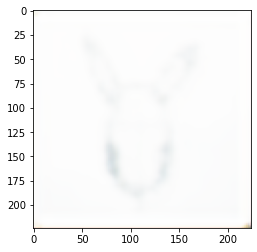

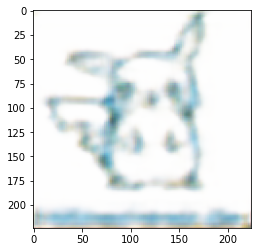

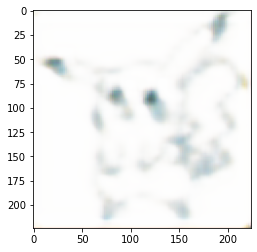

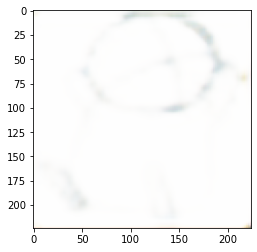

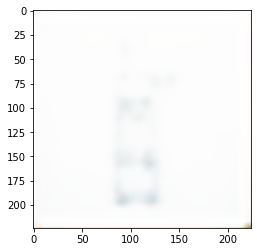

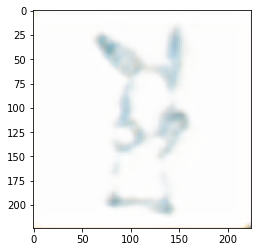

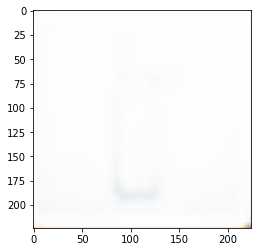

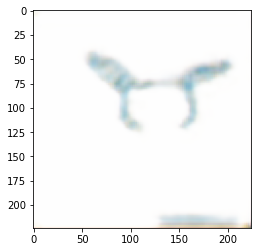

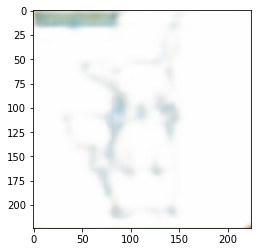

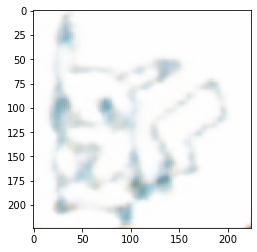

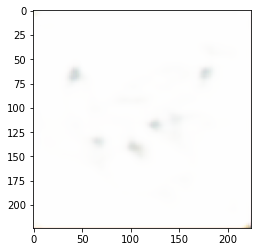

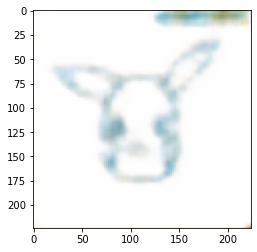

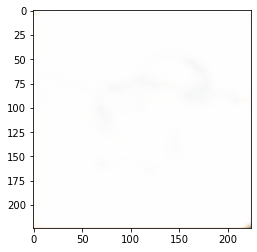

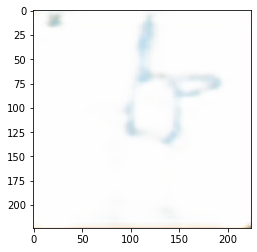

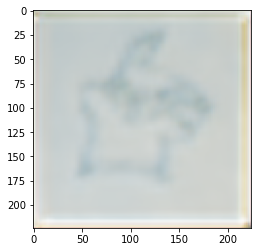

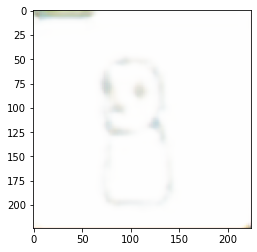

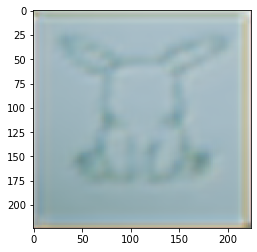

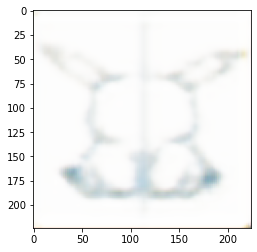

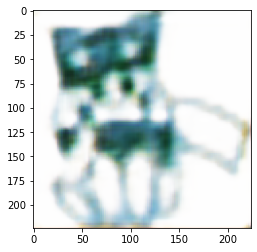

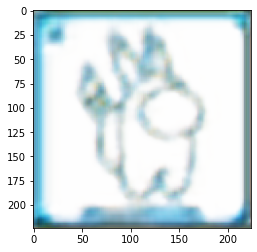

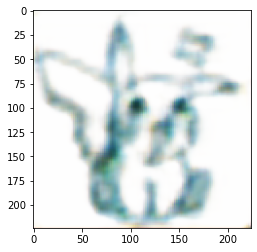

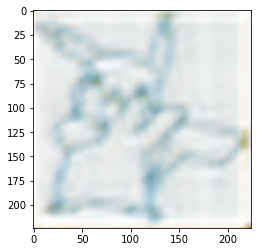

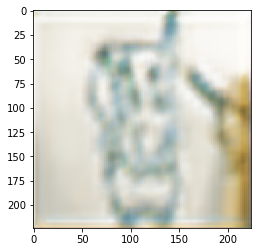

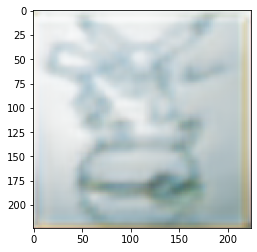

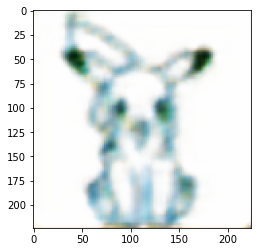

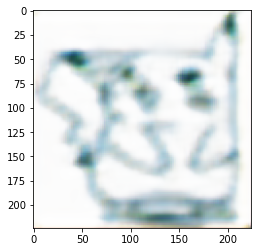

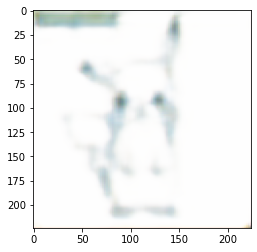

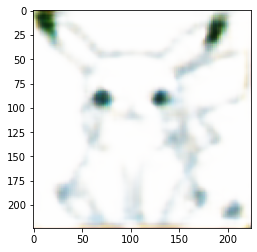

In [45]:
for i in range(len(result)):
    plt.imshow(result[i])
    plt.show()